**PROBLEM STATEMENT**

Let $p = (p_1, p_2, \ldots, p_S)$ be a discrete probability distribution over an alphabet of size $S$, with symbols that we denote by $1, \ldots, S$, and let $X = (X^1, X^2, \ldots, X^n)$ be a sample with $n$ instances sampled from $p$. The problem here is to estimate the number of unseen symbols in the alphabet that would be observed at least $\mu$ times in case we collected another sample $Y = (Y^1, Y^2, \ldots, Y^m)$ containing $m$ instances from $p$. For convenience, we will write $m$ as $m=an$, where $a$ is called the amplification factor. That is, we want to estimate the quantity $$U_{\mu} = \sum \limits _{i=1}^{S} \mathbf{1}_{n_{i}=0} \cdot \mathbf{1}_{m_{i} \geq \mu},$$ where $n_{i}$ and $m_{i}$ are the number of times the symbol $i$ is observed in $X$ and $Y$, respectively, and $\mathbf{1}_{x}$ is a Bernoulli random variable that assumes 1 in case statement $x$ is true, and zero otherwise.

The goal here is to estimate $U_{\mu}$ using the estimator proposed in the paper "Optimal Prediction of the Number of Unseen
Species with Multiplicity", written by Yi Hao and Ping Li, in 2020. 

**THE ESTIMATOR**

The estimator proposed in the aforementioned paper is given by $$\hat{U_{\mu}} = \sum \limits_{i=1}^{n} s_{i} \Phi_{i},$$ where $\Phi_{i}$ is the number of symbols that were observed $i$ times in $X$, and $s_i$ is defined as $$s_i = - \sum \limits_{j=0}^{\min (\mu - 1, i)} (-a)^{i}(-1)^{j} \binom{i}{j} \cdot P(\text{Poi}(r) \geq i+j),$$ where $r$ is a smoothing parameter. In the papers, the authors suggested to use $$r = \frac{\log(n(a+1)^2/(a-1))}{2a}.$$

In the paper, the authors provide some theoretical bounds that show that the largest $a$ for which the above estimator delivers accurate results is around $\log(n)/\mu$.

This estimator will be testing under different distributions, reproducing the results presented in the paper. 

**EXPERIMENTAL SETTING**

- Alphabet size: 10000

- Sample size: 5000

- Multiplicity: $\mu = 1, 2, 3$

- Amplification factor: $a= 1, 2, \ldots, 10$

Distributions: 

- Uniform distribution (P1)

- Two-step distribution with half of the symbols having probability $\frac{1}{2S}$ and the other half having probability $\frac{3}{2S}$ (P2)

- Two Zipf distributions with parameters $\alpha = 0.5, 1$ satisfying $p_i \propto i^{-\alpha}$ truncated at $i=S$ and renormalized (P3) and (P4)

- Two distributions generated by Dirichlet distributions with parameters $0.5$ and $1$ (P5) and (P6)

In [2]:
using Statistics
using PyPlot
using Distributions

In [3]:
S = 10000; #alphabet size
n = 5000;  #sample size

####GENERATING DISTRIBUTIONS 
P1 = ones(S)/S #UNIFORM
P2 = vcat(ones(Int(S/2))/(2*S), ones(Int(S/2))*3/(2*S)) #TWO-STEP
alfa = 0.5; P3 = collect(1:1:S).^(-alfa); P3 = P3/sum(P3) #Zipf 0.5
alfa = 1; P4 = collect(1.0:1.0:S).^(-alfa); P4 = P4/sum(P4); #Zipf 1
alfa = ones(S)*0.5; d = Dirichlet(alfa); P5 = rand(d); #Dirichlet prior 1/2
alfa = ones(S); d = Dirichlet(alfa); P6 = rand(d); #Dirichlet prior 1


In [146]:
function draw_from_distribution(p, n) #draw n_samples from the distribution p 
    CDF = cumsum(p)
    aux = rand(n)
    x = [findall(CDF.>=aux[i])[1] for i in 1:n]
    return x 
end 

function generate_two_samples(p, S, n, a)
    m = n*a 
    x = draw_from_distribution(p, n)
    y = draw_from_distribution(p, m)
    return x,y 
end 

#the function belows count the amount of symbols that were not observed in x but was observed at least mu times in y
function count_U(x, y, mu)
    unique_x = unique(x)
    unique_y = unique(y)
    new_symbols = setdiff(unique_y, unique_x)
    new_symbols_count = [sum(y.==i) for i in new_symbols] 
    U = sum(new_symbols_count.>=mu)
    return U
end 

#=the following functions takes as input a sample vector of size n and returns another n-dimensional vector where i-th element is the number of 
symbols that were observed exactly i times in x=#
function histogram_of_counts(x) 
    n = length(x)
    unique_x = unique(x)
    symbols_counts = [sum(x.==i) for i in unique_x] 
    Phi = [sum(symbols_counts.==i) for i in 1:n]
    return Phi 
end 

function obtain_factorial(x)
    if x == 0 
        return 1 
    else 
        return x*obtain_factorial(x-1)
    end 
end

function factorial_division(n, k) #n!/k! with k 
    if n==k 
        return 1
    else 
        return n*factorial_division(n-1, k)
    end 
end

poisson_tail(r, z) = ccdf(Poisson(r), z-1)

function binom_coefficient(x,y) 
    return factorial_division(x, x-y)/(obtain_factorial(y))
end

function get_s(i, mu, a, r, PHI)
    if PHI[i]>0
        sum_lim = min(i, mu-1)
        #tail = [poisson_tail(r,i+j) for j in 0:sum_lim]
        #aux_vec = [tail[j+1]>1e-10 ? ((-a)^i)*((-1)^j)*binom_coefficient(i,j)*tail[j+1] : 0 for j in 0:sum_lim]
        aux_vec = [((-a)^i)*((-1)^j)*binom_coefficient(i,j)*poisson_tail(r,i+j) for j in 0:sum_lim]
        aux_vec = -1*aux_vec
        return sum(aux_vec)
    else 
        return 0
    end 
end

function estimate_u(x, mu, a, r)
    n = length(x)
    s = zeros(n) 
    PHI = histogram_of_counts(x)
    last_nonzero = findall(PHI.>0)[end]
    s_aux = [get_s(i, mu, a, r, PHI) for i in 1:last_nonzero]
    s[1:last_nonzero] = s_aux
    U = s'*PHI
    return U 
end

estimate_u (generic function with 1 method)

1
2
3


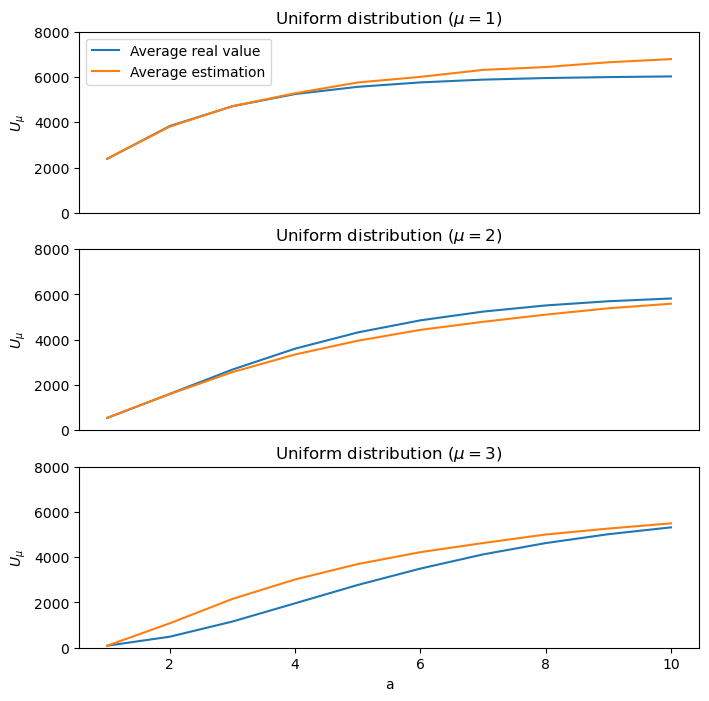

In [139]:
a_vals = collect(1:1:10)


mus = [1,2,3]
reals = []
estimations = []

for mu in mus
  println(mu) 
  avg_reals = []
  avg_estimations = []
  for a in a_vals 
    accum_reals = []
    accum_estimations = []
    r = log(n*(a+1)^2/(a-1))/(2*a)
    for i in 1:100
      x, y = generate_two_samples(P1, S, n, a)  
      push!(accum_reals, count_U(x,y, mu))
      push!(accum_estimations, estimate_u(x, mu, a, r))
    end 
    push!(avg_reals, mean(accum_reals))
    push!(avg_estimations, mean(accum_estimations))
  end 
  push!(reals, avg_reals)
  push!(estimations, avg_estimations)
end


figure(figsize=(8,8))
subplot(311)
plot(a_vals, reals[1])
plot(a_vals, estimations[1])
title(L"Uniform distribution ($\mu = 1$)")
xticks([])
ylim([0,8000])
ylabel(L"$U_\mu$")
legend(["Average real value", "Average estimation"])
subplot(312)
plot(a_vals, reals[2])
plot(a_vals, estimations[2])
title(L"Uniform distribution ($\mu = 2$)")
xticks([])
ylim([0,8000])
ylabel(L"$U_\mu$")
subplot(313)
plot(a_vals, reals[3])
plot(a_vals, estimations[3])
title(L"Uniform distribution ($\mu = 3$)")
xlabel("a")
ylim([0,8000])
ylabel(L"$U_\mu$")
display(gcf())


1
2
3


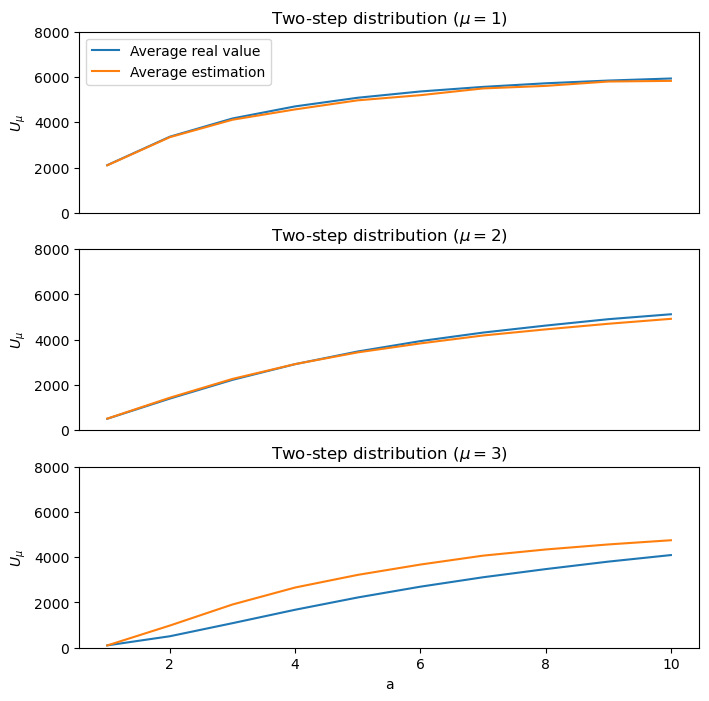

In [137]:
a_vals = collect(1:1:10)


mus = [1,2,3]
reals = []
estimations = []

for mu in mus
  println(mu) 
  avg_reals = []
  avg_estimations = []
  for a in a_vals 
    accum_reals = []
    accum_estimations = []
    r = log(n*(a+1)^2/(a-1))/(2*a)
    for i in 1:100
      x, y = generate_two_samples(P2, S, n, a)  
      push!(accum_reals, count_U(x,y, mu))
      push!(accum_estimations, estimate_u(x, mu, a, r))
    end 
    push!(avg_reals, mean(accum_reals))
    push!(avg_estimations, mean(accum_estimations))
  end 
  push!(reals, avg_reals)
  push!(estimations, avg_estimations)
end


figure(figsize=(8,8))
subplot(311)
plot(a_vals, reals[1])
plot(a_vals, estimations[1])
title(L"Two-step distribution ($\mu = 1$)")
xticks([])
ylim([0,8000])
ylabel(L"$U_\mu$")
legend(["Average real value", "Average estimation"])
subplot(312)
plot(a_vals, reals[2])
plot(a_vals, estimations[2])
title(L"Two-step distribution ($\mu = 2$)")
xticks([])
ylim([0,8000])
ylabel(L"$U_\mu$")
subplot(313)
plot(a_vals, reals[3])
plot(a_vals, estimations[3])
title(L"Two-step distribution ($\mu = 3$)")
xlabel("a")
ylim([0,8000])
ylabel(L"$U_\mu$")
display(gcf())


1
2
3


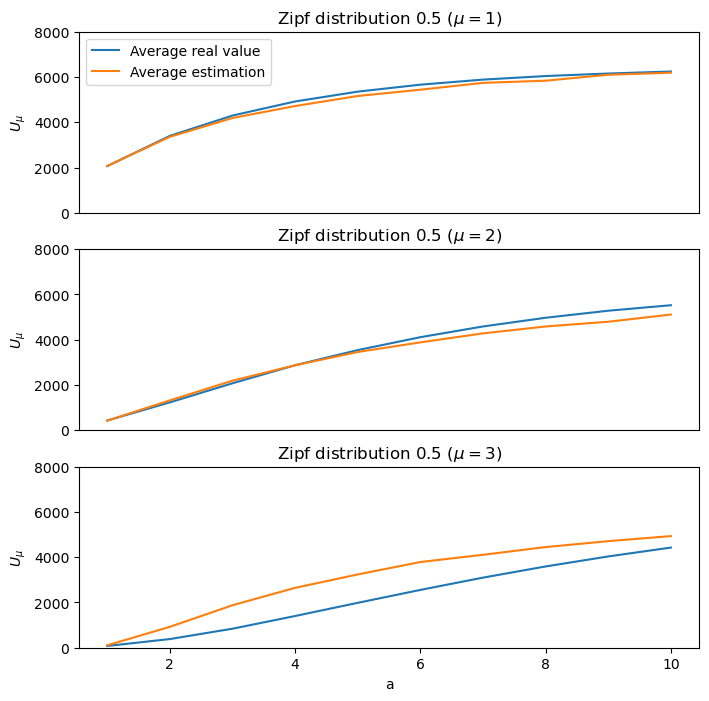

In [140]:
a_vals = collect(1:1:10)


mus = [1,2,3]
reals = []
estimations = []

for mu in mus
  println(mu) 
  avg_reals = []
  avg_estimations = []
  for a in a_vals 
    accum_reals = []
    accum_estimations = []
    r = log(n*(a+1)^2/(a-1))/(2*a)
    for i in 1:100
      x, y = generate_two_samples(P3, S, n, a)  
      push!(accum_reals, count_U(x,y, mu))
      push!(accum_estimations, estimate_u(x, mu, a, r))
    end 
    push!(avg_reals, mean(accum_reals))
    push!(avg_estimations, mean(accum_estimations))
  end 
  push!(reals, avg_reals)
  push!(estimations, avg_estimations)
end


figure(figsize=(8,8))
subplot(311)
plot(a_vals, reals[1])
plot(a_vals, estimations[1])
title(L"Zipf distribution 0.5 ($\mu = 1$)")
xticks([])
ylim([0,8000])
ylabel(L"$U_\mu$")
legend(["Average real value", "Average estimation"])
subplot(312)
plot(a_vals, reals[2])
plot(a_vals, estimations[2])
title(L"Zipf distribution 0.5 ($\mu = 2$)")
xticks([])
ylim([0,8000])
ylabel(L"$U_\mu$")
subplot(313)
plot(a_vals, reals[3])
plot(a_vals, estimations[3])
title(L"Zipf distribution 0.5 ($\mu = 3$)")
xlabel("a")
ylim([0,8000])
ylabel(L"$U_\mu$")
display(gcf())

1
2
3


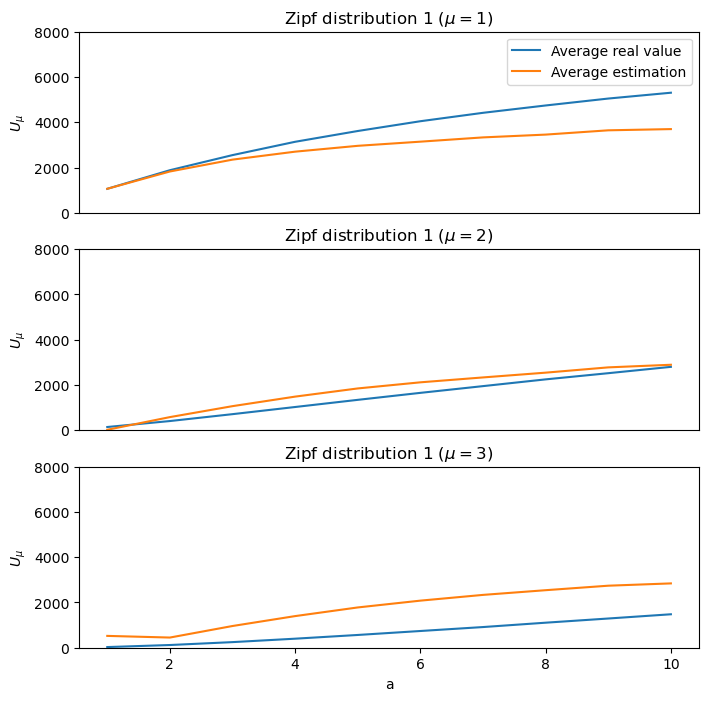

In [141]:
a_vals = collect(1:1:10)


mus = [1,2,3]
reals = []
estimations = []

for mu in mus
  println(mu) 
  avg_reals = []
  avg_estimations = []
  for a in a_vals 
    accum_reals = []
    accum_estimations = []
    r = log(n*(a+1)^2/(a-1))/(2*a)
    for i in 1:100
      x, y = generate_two_samples(P4, S, n, a)  
      push!(accum_reals, count_U(x,y, mu))
      push!(accum_estimations, estimate_u(x, mu, a, r))
    end 
    push!(avg_reals, mean(accum_reals))
    push!(avg_estimations, mean(accum_estimations))
  end 
  push!(reals, avg_reals)
  push!(estimations, avg_estimations)
end


figure(figsize=(8,8))
subplot(311)
plot(a_vals, reals[1])
plot(a_vals, estimations[1])
title(L"Zipf distribution 1 ($\mu = 1$)")
xticks([])
ylim([0,8000])
ylabel(L"$U_\mu$")
legend(["Average real value", "Average estimation"])
subplot(312)
plot(a_vals, reals[2])
plot(a_vals, estimations[2])
title(L"Zipf distribution 1 ($\mu = 2$)")
xticks([])
ylim([0,8000])
ylabel(L"$U_\mu$")
subplot(313)
plot(a_vals, reals[3])
plot(a_vals, estimations[3])
title(L"Zipf distribution 1 ($\mu = 3$)")
xlabel("a")
ylim([0,8000])
ylabel(L"$U_\mu$")
display(gcf())

1
2
3


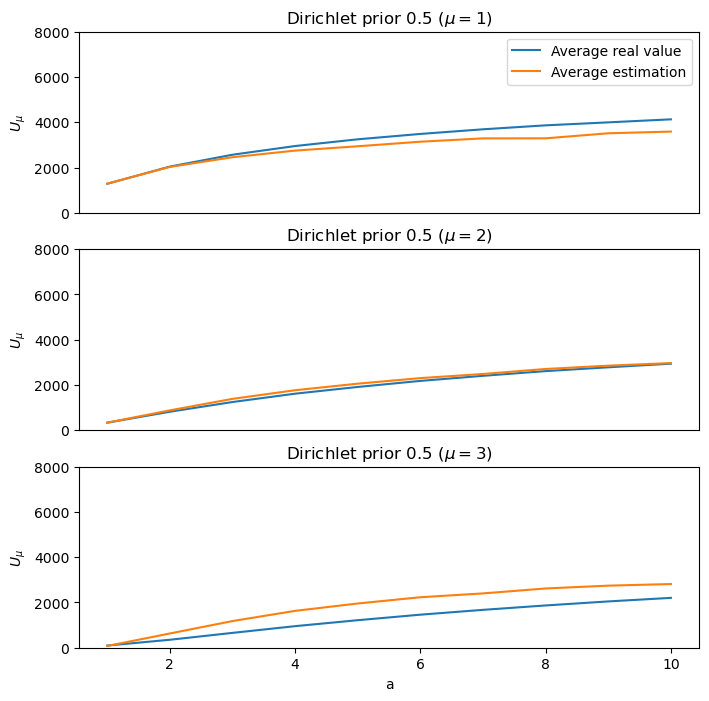

In [144]:
a_vals = collect(1:1:10)


mus = [1,2,3]
reals = []
estimations = []

for mu in mus
  println(mu) 
  avg_reals = []
  avg_estimations = []
  for a in a_vals 
    accum_reals = []
    accum_estimations = []
    r = log(n*(a+1)^2/(a-1))/(2*a)
    for i in 1:100
      x, y = generate_two_samples(P5, S, n, a)  
      push!(accum_reals, count_U(x,y, mu))
      push!(accum_estimations, estimate_u(x, mu, a, r))
    end 
    push!(avg_reals, mean(accum_reals))
    push!(avg_estimations, mean(accum_estimations))
  end 
  push!(reals, avg_reals)
  push!(estimations, avg_estimations)
end


figure(figsize=(8,8))
subplot(311)
plot(a_vals, reals[1])
plot(a_vals, estimations[1])
title(L"Dirichlet prior 0.5 ($\mu = 1$)")
xticks([])
ylim([0,8000])
ylabel(L"$U_\mu$")
legend(["Average real value", "Average estimation"])
subplot(312)
plot(a_vals, reals[2])
plot(a_vals, estimations[2])
title(L"Dirichlet prior 0.5 ($\mu = 2$)")
xticks([])
ylim([0,8000])
ylabel(L"$U_\mu$")
subplot(313)
plot(a_vals, reals[3])
plot(a_vals, estimations[3])
title(L"Dirichlet prior 0.5 ($\mu = 3$)")
xlabel("a")
ylim([0,8000])
ylabel(L"$U_\mu$")
display(gcf())

1
2
3


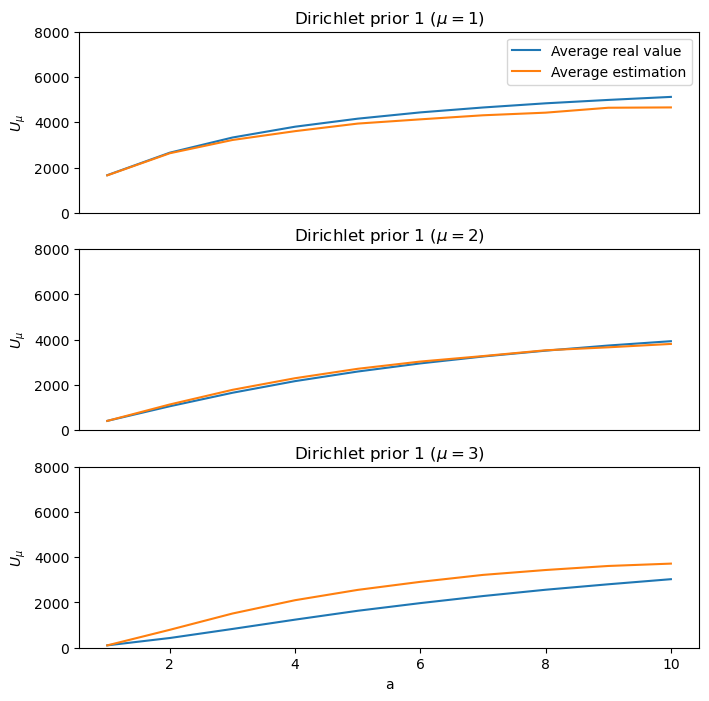

In [145]:
a_vals = collect(1:1:10)


mus = [1,2,3]
reals = []
estimations = []

for mu in mus
  println(mu) 
  avg_reals = []
  avg_estimations = []
  for a in a_vals 
    accum_reals = []
    accum_estimations = []
    r = log(n*(a+1)^2/(a-1))/(2*a)
    for i in 1:100
      x, y = generate_two_samples(P6, S, n, a)  
      push!(accum_reals, count_U(x,y, mu))
      push!(accum_estimations, estimate_u(x, mu, a, r))
    end 
    push!(avg_reals, mean(accum_reals))
    push!(avg_estimations, mean(accum_estimations))
  end 
  push!(reals, avg_reals)
  push!(estimations, avg_estimations)
end


figure(figsize=(8,8))
subplot(311)
plot(a_vals, reals[1])
plot(a_vals, estimations[1])
title(L"Dirichlet prior 1 ($\mu = 1$)")
xticks([])
ylim([0,8000])
ylabel(L"$U_\mu$")
legend(["Average real value", "Average estimation"])
subplot(312)
plot(a_vals, reals[2])
plot(a_vals, estimations[2])
title(L"Dirichlet prior 1 ($\mu = 2$)")
xticks([])
ylim([0,8000])
ylabel(L"$U_\mu$")
subplot(313)
plot(a_vals, reals[3])
plot(a_vals, estimations[3])
title(L"Dirichlet prior 1 ($\mu = 3$)")
xlabel("a")
ylim([0,8000])
ylabel(L"$U_\mu$")
display(gcf())